In [159]:
start_x = 0
end_x = 965 # meters
T = 60 * 3    # seconds; upper bound 
t = [1:T;]
t_green_duration = 20 # seconds
t_red_duration = 24   # seconds, plus yellow time 4 seconds

min_v = 6 # m/s
max_v = 19

using JuMP, Gurobi

m = Model(solver=MosekSolver(LOG = 0))
@variable(m, x[1:T])    # position at time t
@variable(m, v[1:T] <= max_v)    # velocity at time t
@variable(m, a[1:T-1])  # acceleration at time t 
@variable(m, t_r[1:T])  # time until turns red 
@variable(m, t_g[1:T])  # time until turns green

# assumption starts with green, at time = 0 it's green 
for i=1:T
    j = i%44
    if j<=23
        @constraint(m, t_r[i] == t_red_duration - j + 1)
        @constraint(m, t_g[i] == 0)
    else
        @constraint(m, t_r[i] == 0)
        @constraint(m, t_g[i] == t_green_duration - j + 24)
    end
end
        
@constraint(m, dynamics[i in 1:T-1], x[i+1] == x[i] + a[i]/2 + v[i]) # per second, x = at^2*0.5 + vt
@constraint(m, velocity_change[i in 1:T-1], v[i+1] == v[i] + a[i])   # per second, v = v_initial + at 
@constraint(m, x[T] == end_x)
@constraint(m, v[T] == 0)
@constraint(m, v[1] == 0)
@constraint(m, vel_min[i in 2:T-2], v[i] >= min_v)

coeff = [0.000111703,-0.0108393,0.376853,-5.32999,30.7955]
@NLobjective(m, Min, sum(sum(coeff[k]*v[i]^(4-k+1) for k in 1:5) for i=1:T))

solve(m)
vopt = getvalue(v)
println(vopt)
println(getobjectivevalue(m))

[6.05463e-9,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3528,13.3

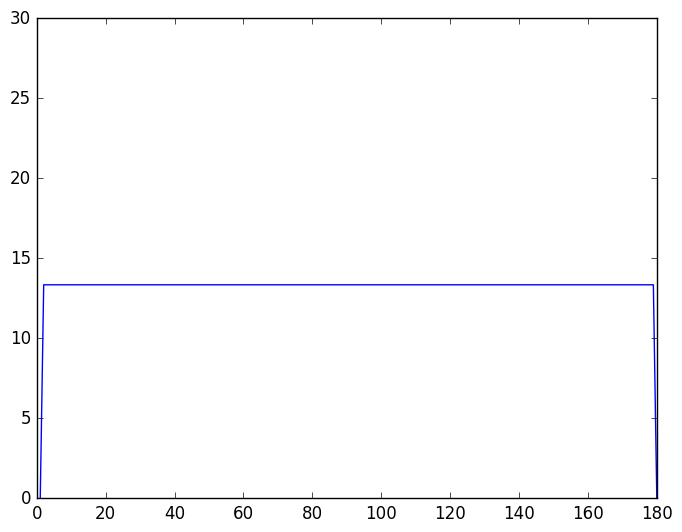

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x328ee66d0>

In [151]:
using PyPlot
ylim(0,30)
plot(t,vopt)

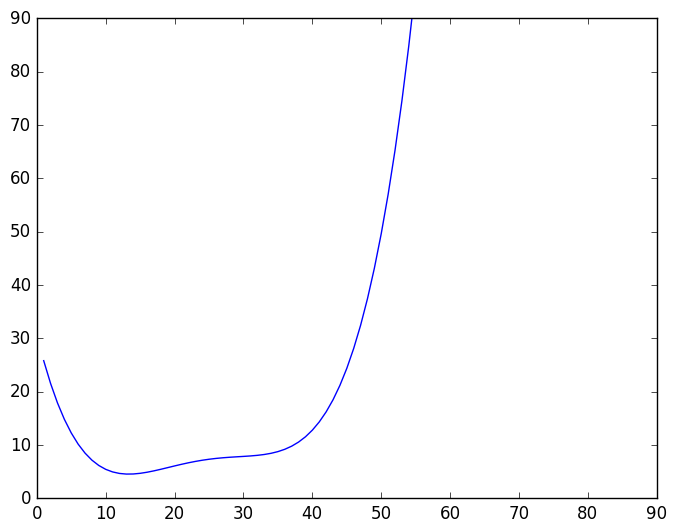

5.780110963000023
6.094980000000003
7.348796875000016


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32a813f50>

In [164]:
using PyPlot
ylim(0,90)
x = [1:90;]
coeff = [0.000111703,-0.0108393,0.376853,-5.32999,30.7955]
for i= 1:90
    y[i] = sum(coeff[k] * x[i]^(4-k+1) for k=1:5)
end
println(sum(coeff[k] * 19^(4-k+1) for k=1:5))
println(sum(coeff[k] * 20^(4-k+1) for k=1:5)) 
println(sum(coeff[k] * 25^(4-k+1) for k=1:5))
plot(x,y)

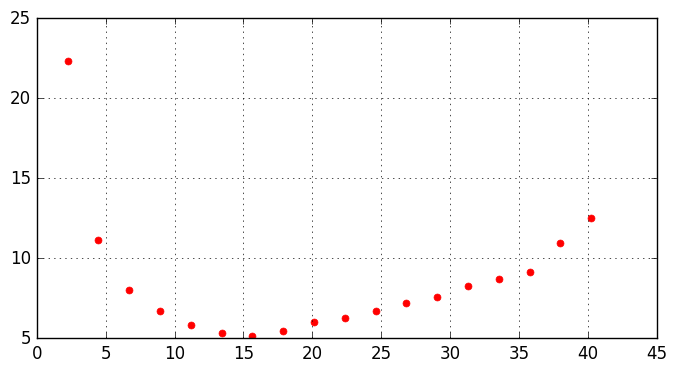

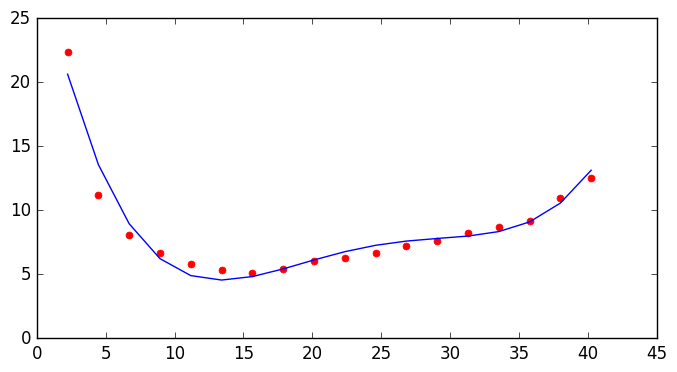

[0.000111703,-0.0108393,0.376853,-5.32999,30.7955]


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32a46bf10>

In [148]:
# define (x,y) coordinates of the points
x_m = [ 5,  10, 15, 20, 25, 30, 35,   40,   45,   50,   55,   60,   65,   70,   75, 80, 85, 90 ]
y_m = [ 50, 25, 18, 15, 13, 12, 11.5, 12.2, 13.5, 14,   15,   16.2,   17,   18.5,   19.5, 20.5, 24.5, 28 ]
x = 0.44704 .* x_m
y = 0.44704 .* y_m

using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
#xlim([0,10]); 
#ylim([0,55])
grid("on")
# order of polynomial to use
k = 4

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

# NOTE: must have either Gurobi or Mosek installed!

using JuMP, Gurobi, Mosek

#m = Model(solver=MosekSolver(LOG=0))
m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
solve(m)
uopt = getvalue(u)
println(uopt)

using PyPlot
npts = length(x)
xfine = x #linspace(1,90,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
#xlim([0,10]); 
#ylim([0,55]); grid()